In [1]:
#dezipe folder image
import zipfile

zip_path = 'meat_dataset.zip'      
extract_dir = 'images_dataset_meat'       

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [3]:
#verif nombre d'image par variable
import os

for category in ['fresh', 'spoiled']:
    path = os.path.join('images_dataset_meat', category)
    print(f"{category} : {len(os.listdir(path))} images")

fresh : 1801 images
spoiled : 1572 images


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import AUC, Precision, Recall
import datetime
import matplotlib.pyplot as plt

# Configuration si besoin de reproduire
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Config parameters
IMG_SIZE = (224, 224)  # augmentation taille des images
BATCH_SIZE = 32
EPOCHS_INITIAL = 15
EPOCHS_FINETUNE = 20
LEARNING_RATE_INITIAL = 1e-4
LEARNING_RATE_FINETUNE = 5e-5
MODEL_DIR = 'saved_models'
os.makedirs(MODEL_DIR, exist_ok=True)

# config mémoire GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"GPU disponible: {len(physical_devices)}")
    except:
        print("Erreur lors de la configuration GPU")
else:
    print("Pas de GPU disponible, utilisation du CPU")

# data augment
datagen_train = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    shear_range=0.2,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# data loading
train_generator = datagen_train.flow_from_directory(
    'images_dataset_meat',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=SEED
)
val_generator = datagen_val.flow_from_directory(
    'images_dataset_meat',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,  # Pour une évaluation cohérente
    seed=SEED
)

# calcul des weights pour savoir si désequilibre
class_counts = np.bincount(train_generator.classes)
total_samples = np.sum(class_counts)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}
print(f"Distribution des classes: {class_counts}")
print(f"Poids des classes: {class_weights}")

# j'ai choisi DenseNet
base_model = DenseNet121(
    weights='imagenet', 
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_INITIAL),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

model.summary()

log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, 'best_model_phase1.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

# premier training
print("Phase 1: Entraînement en mode extraction de caractéristiques...")
history = model.fit(
    train_generator,
    epochs=EPOCHS_INITIAL,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# load du meilleur modèle en training 1
model = load_model(os.path.join(MODEL_DIR, 'best_model_phase1.h5'))

# fine tune avec defreeze progressif
print("Phase 2: Fine-tuning du modèle...")
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

print("Couches dégelées pour fine-tuning:")
for i, layer in enumerate(base_model.layers[-60:]):
    print(f"{i+len(base_model.layers)-60}. {layer.name}, trainable: {layer.trainable}")

# compilation 
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_FINETUNE),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

# Maj des callbacks pour la phase 2
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, 'best_model_final.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    TensorBoard(log_dir=log_dir, histogram_freq=1)
]

# training fine tuning
history_ft = model.fit(
    train_generator,
    epochs=EPOCHS_FINETUNE,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# éval finale
# charge le meilleur modèle final
best_model = load_model(os.path.join(MODEL_DIR, 'best_model_final.h5'))

# evaluation du le modèle
evaluation = best_model.evaluate(val_generator, verbose=1)
print("Métriques finales:")
for i, metric_name in enumerate(best_model.metrics_names):
    print(f"{metric_name}: {evaluation[i]:.4f}")


Modèle sauvegardé dans saved_models\meat_classifier_model


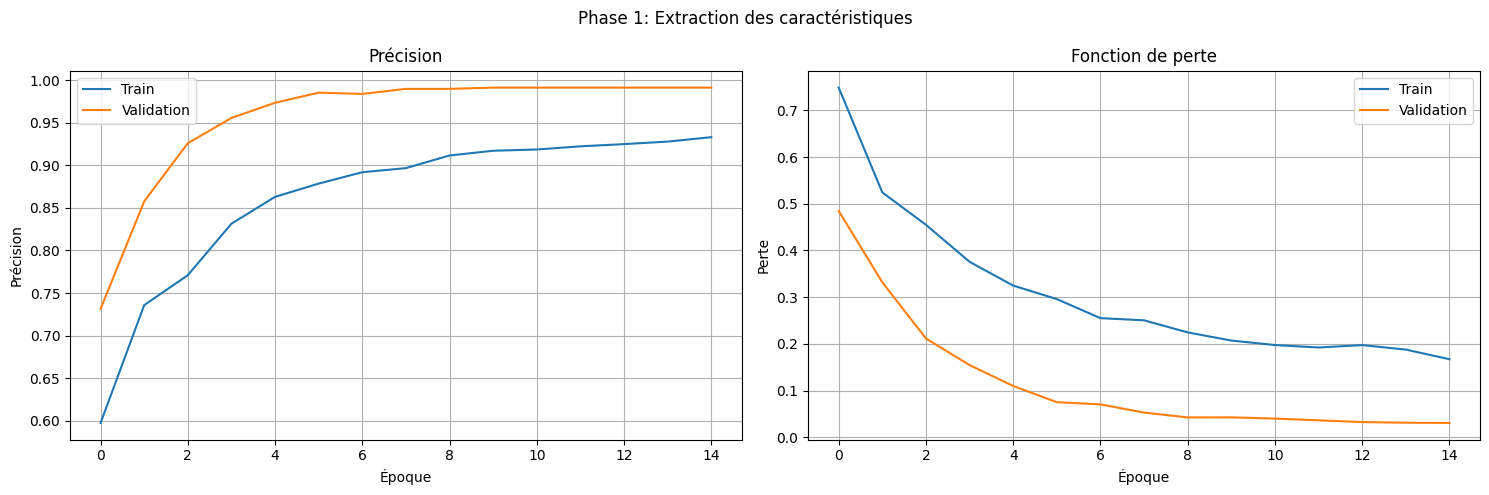

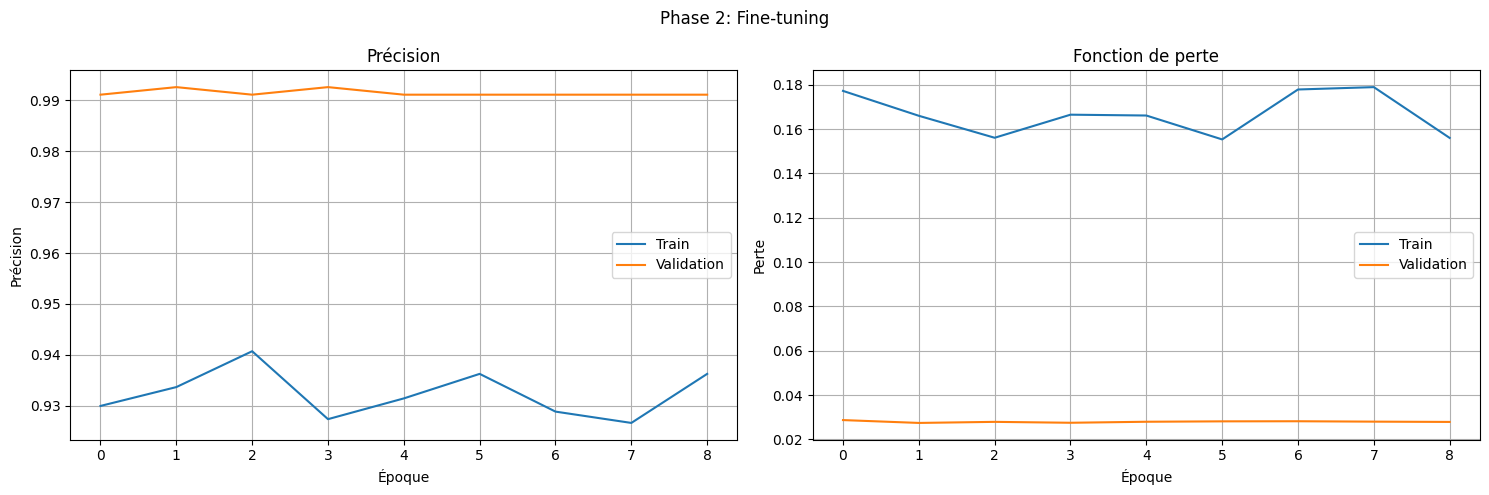

Entraînement terminé!


In [11]:

# save the model
save_model(
    best_model, 
    os.path.join(MODEL_DIR, 'meat_classifier_model.keras')
)
print(f"Modèle sauvegardé dans {os.path.join(MODEL_DIR, 'meat_classifier_model')}")

# histo entrainement
def plot_training_history(history, title="Métriques d'entraînement"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # precision
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Précision')
    ax1.set_ylabel('Précision')
    ax1.set_xlabel('Époque')
    ax1.legend()
    ax1.grid(True)
    
    # losss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Fonction de perte')
    ax2.set_ylabel('Perte')
    ax2.set_xlabel('Époque')
    ax2.legend()
    ax2.grid(True)
    
    fig.suptitle(title)
    fig.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, f"{title.lower().replace(' ', '_')}.png"))
    plt.show()

plot_training_history(history, "Phase 1: Extraction des caractéristiques")
plot_training_history(history_ft, "Phase 2: Fine-tuning")

print("Entraînement terminé!")

In [7]:
#-----------------------------------#
#prédiction sur de nouvelles images : 
#-----------------------------------#
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = 'images_dataset_meat/Spoiled/test_20171017_230521D.jpg'
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
print('Fresh' if prediction[0][0] < 0.5 else 'Spoiled')

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Spoiled


In [ ]:
#pour recharger le modèle
##########################
from tensorflow.keras.models import load_model
model = load_model('meat_fresh_model.keras')

In [ ]:
import matplotlib.pyplot as plt

img = image.load_img(img_path, target_size=(128, 128))
plt.imshow(img)
plt.title(f"Prédiction : {'Fresh' if prediction[0][0] < 0.5 else 'Spoiled'}", fontsize=16, color='green' if prediction[0][0] < 0.5 else 'red')
plt.axis('off')
plt.show()

In [ ]:
#dashboard interractif streamlite
#import streamlit as st
#from tensorflow.keras.preprocessing import image
#import numpy as np

#st.title("Classificateur de viande : Fresh vs Spoiled")

#uploaded_file = st.file_uploader("Choisis une image...", type=["jpg", "jpeg", "png"])
#if uploaded_file is not None:
 #   img = image.load_img(uploaded_file, target_size=(128, 128))
  #  st.image(img, caption='Image chargée', use_column_width=True)
   # img_array = image.img_to_array(img) / 255.0
    #img_array = np.expand_dims(img_array, axis=0)
    #prediction = model.predict(img_array)
    #label = 'Fresh' if prediction[0][0] < 0.5 else 'Spoiled'
    #st.markdown(f"### Prédiction : {label}")